In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
is_ipython = True
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')
    
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [3]:
from __future__ import absolute_import 
import os
import sys
import numpy as np
import gym
from gym import wrappers
import tensorflow as tf

from models.option_critic_network import OptionsNetwork
from helper.buffer import ReplayBuffer
from helper.state_processor import StateProcessor

#execfile("models/option_critic_network.py")
#execfile("helper/buffer.py")
#execfile("helper/state_processor.py")


# ========================================
#   Utility Parameters
# ========================================
# Render gym env during training
RENDER_ENV = True
# Use Gym Monitor
GYM_MONITOR_EN = True
# Gym environment
ENV_NAME = 'Pong-v0'
# Directory for storing gym results
MONITOR_DIR = '../results2/gym_ddpg'
# Directory for storing tensorboard summary results
SUMMARY_DIR = '../results2/tf_ddpg'
# Seed
RANDOM_SEED = 1234
# np.random.seed(RANDOM_SEED)

# ==========================
#   Training Parameters
# ==========================
# Update Frequency
update_freq = 4
# Max training steps
MAX_EPISODES = 8000
# Max episode length
MAX_EP_STEPS = 250000
# Maximum frames per game
MAX_STEPS = 18000
# Base learning rate for the Actor network
ACTOR_LEARNING_RATE = 0.00025
# Base learning rate for the Critic Network
CRITIC_LEARNING_RATE = 0.00025
# Contributes to the nitial random walk
MAX_START_ACTION_ATTEMPTS = 30
# Update params
FREEZE_INTERVAL = 10000
# Discount factor
GAMMA = 0.99
# Soft target update param
TAU = 0.001
# Starting chance of random action
START_EPS = 1
# Final chance of random action
END_EPS = 0.1
# How many steps of training to reduce startE to endE.
ANNEALING = 1000000
# Number of options
OPTION_DIM = 8
# Pretrain steps
PRE_TRAIN_STEPS = 50000
# Size of replay buffer
BUFFER_SIZE = 1000000
# Minibatch size
MINIBATCH_SIZE = 32



In [4]:
# ===========================
#   Tensorflow Summary Opself.model
# ===========================


def build_summaries():
    summary_ops = tf.Summary()
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("DOCA/Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("DOCA/Qmax Value", episode_ave_max_q)
    episode_termination_ratio = tf.Variable(0.)
    tf.summary.scalar("DOCA/Term Ratio", episode_termination_ratio)
    tot_reward = tf.Variable(0.)
    tf.summary.scalar("DOCA/Total Reward", tot_reward)
    cum_reward = tf.Variable(0.)
    tf.summary.scalar("DOCA/Cummulative Reward", tot_reward)
    rmng_frames = tf.Variable(0.)
    tf.summary.scalar("DOCA/Remaining Frames", rmng_frames)

    summary_vars = [
        episode_reward, episode_ave_max_q,
        episode_termination_ratio, tot_reward, cum_reward, rmng_frames]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars


def get_reward(reward):
    if reward < 0:
        score = -1
    elif reward > 0:
        score = 1
    else:
        score = 0

    return score, reward

def get_epsilon(frm_count):
    #linear descent from 1 to 0.1 starting at the replay_start_time
    replay_start_time = max([float(frm_count)-PRE_TRAIN_STEPS, 0])
    epsilon = START_EPS
    epsilon -= (START_EPS - END_EPS)*\
      (min(replay_start_time, ANNEALING)/float(ANNEALING))
    return epsilon



In [5]:
# ===========================
#   Agent Training
# ===========================


def train(sess, env, option_critic):  # , critic):
    # Set up summary Ops
    summary_ops, summary_vars = build_summaries()
    np.random.seed(RANDOM_SEED)
    rng = np.random.RandomState(RANDOM_SEED)

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)

    # Initialize target network weights
    option_critic.update_target_network()
    # critic.update_target_network()

    # State processor
    state_processor = StateProcessor()

    # Initialize replay memory
    replay_buffer = ReplayBuffer(84, 84, rng, BUFFER_SIZE, 4)
    frame_count = 0
    print_option_stats = False
    # Initialize action counter to 0
    action_counter = [{j: 0 for j in range(
        env.action_space.n)} for i in range(OPTION_DIM)]
    total_reward = 0
    counter = 0
    for i in range(MAX_EPISODES):
        term_probs = []
        start_frames = frame_count

        while MAX_EP_STEPS > (frame_count - start_frames):
            # if RENDER_ENV:
            #     env.render()

            current_state = env.reset()  # note I'm using only one step, original uses 4
            current_state = state_processor.process(sess, current_state)
            current_state = np.stack([current_state] * 4, axis=2)
            current_option = 0
            current_action = 0
            new_option = np.argmax(option_critic.predict(current_state))
            #+ (1./(1. + i)) # state has more than 3 features in pong
            done = False
            termination = True
            ep_reward = 0
            ep_ave_max_q = 0
            termination_counter = 0
            since_last_term = 1
            game_over = False

            start_frame_count = frame_count
            episode_counter = 0

            while not game_over:
                frame_count += 1
                episode_counter += 1
                eps = get_epsilon(frame_count)
                if termination:
                    if print_option_stats:
                        print("terminated ------- {}".format(since_last_term))

                    termination_counter += 1
                    since_last_term = 1
                    current_option = np.random.randint(OPTION_DIM) \
                        if np.random.rand() < eps else new_option
                else:
                    if print_option_stats:
                        print("keep going")

                    since_last_term += 1

                action_probs = option_critic.predict_action(
                    [current_state], np.reshape(current_option, [1, 1]))[0]
                current_action = np.argmax(np.random.multinomial(1, action_probs))
                if print_option_stats:
                    if print_option_stats:
                        action_counter[current_option][current_action] += 1
                        data_table = []
                        option_count = []
                        for ii, aa in enumerate(action_counter):
                            s3 = sum([aa[a] for a in aa])
                            if s3 < 1:
                                continue

                            print(ii, aa, s3)
                            option_count.append(s3)
                            print([str(float(aa[a]) / s3)[:5] for a in aa])
                            data_table.append([float(aa[a]) / s3 for a in aa])
                            print

                        print

                next_state, reward, done, info = env.step(current_action)
                next_state = state_processor.process(sess, next_state)
                next_state = np.append(
                    current_state[:, :, 1:],
                    np.expand_dims(next_state, 2),
                    axis=2)
                score, reward = get_reward(reward)
                game_over = done or (frame_count-start_frame_count) > MAX_STEPS

                total_reward += reward

                replay_buffer.add_sample(current_state[:, :, -1], current_option, score, game_over)

                term = option_critic.predict_termination([next_state], [[current_option]])
                option_term_ps, Q_values = term[0], term[1]
                ep_ave_max_q += np.max(Q_values)
                new_option = np.argmax(Q_values)
                randomize = np.random.uniform(size=np.asarray([0]).shape)
                termination = np.greater(option_term_ps[0], randomize)
                if frame_count < PRE_TRAIN_STEPS:
                    termination = 1
                else:

                    # done in the original paper, actor is trained on current data
                    # critic trained on sampled one
                    _ = option_critic.train_actor(
                        [current_state], [next_state],
                        np.reshape(current_option, [1, 1]),
                        np.reshape(current_action, [1, 1]),
                        np.reshape(score, [1, 1]),
                        np.reshape(done + 0, [1, 1]))

                    if frame_count % (update_freq) == 0:
                        if RENDER_ENV:
                            env.render()
                            show_state(env)

                        # Keep adding experience to the memory until
                        # there are at least minibatch size samples
                        # if len(replay_buffer) > MINIBATCH_SIZE:
                        current_state_batch, o_batch, score_batch, next_state_batch, done_batch = \
                            replay_buffer.random_batch(MINIBATCH_SIZE)

                        _ = option_critic.train_critic(
                            current_state_batch, next_state_batch,
                            np.reshape(o_batch, [MINIBATCH_SIZE, 1]),
                            np.reshape(score_batch, [MINIBATCH_SIZE, 1]),
                            np.reshape(done_batch + 0, [MINIBATCH_SIZE, 1]))

                    if frame_count % (FREEZE_INTERVAL) == 0:
                        # Update target networks
                        print("updated params")
                        option_critic.update_target_network()

                current_state = next_state
                ep_reward += reward
                term_ratio = float(termination_counter) / float(episode_counter)
                term_probs.append(term_ratio)

                if done:
                    summary_str = sess.run(summary_ops, feed_dict={
                        summary_vars[0]: ep_reward,
                        summary_vars[1]: ep_ave_max_q / float(episode_counter),
                        summary_vars[2]: 100*term_ratio,
                        summary_vars[3]: total_reward,
                        summary_vars[4]: total_reward / float(counter + 1),
                        summary_vars[5]: (MAX_EP_STEPS - (frame_count - start_frames))
                    })

                    writer.add_summary(summary_str, i)
                    writer.flush()

                    break

            term_ratio = float(termination_counter) / float(episode_counter)
            print('| Reward: %.2i' % int(ep_reward), " | Episode %d" % (counter + 1), \
                ' | Qmax: %.4f' % (ep_ave_max_q / float(episode_counter)), \
                ' | Cummulative Reward: %.1f' % (total_reward / float(counter + 1)), \
                ' | %d Remaining Frames' % (MAX_EP_STEPS - (frame_count - start_frames)), \
                ' | Epsilon: %.4f' % eps, " | Termination Ratio: %.2f" % (100*term_ratio))
            counter += 1

def set_up_gym():

    env = gym.make(ENV_NAME)
    env.seed(RANDOM_SEED)

    if GYM_MONITOR_EN:
        if not RENDER_ENV:
            env = wrappers.Monitor(
                env, MONITOR_DIR, video_callable=None, force=True
            )
        else:
            env = wrappers.Monitor(env, MONITOR_DIR, force=True)

    env.reset()
    return env


def main(_):
    if not os.path.exists(MONITOR_DIR):
        os.makedirs(MONITOR_DIR)

    if not os.path.exists(SUMMARY_DIR):
        os.makedirs(SUMMARY_DIR)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    if state_dim == 210:
        # state_dim *= env.observation_space.shape[1] # for grey scale
        state_dim = 84 * 84 * 4
    # action_bound = env.action_space.high
    # Ensure action bound is symmetric
    # assert(env.action_space.high == -env.action_space.low)

    with tf.Session() as sess:
        tf.set_random_seed(123456)
        # sess, h_size, temp, state_dim, action_dim, option_dim, action_bound, learning_rate, tau
        option_critic = OptionsNetwork(
            sess, 512, 1, state_dim, action_dim, 8, ACTOR_LEARNING_RATE, TAU, GAMMA, clip_delta=1)

        train(sess, env, option_critic)

    # if GYM_MONITOR_EN:
    #     env.monitor.close()

In [ ]:
if __name__ == '__main__':
    env = set_up_gym()
    tf.app.run()

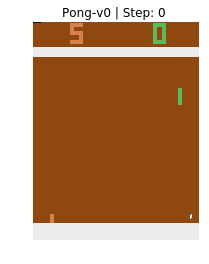

KeyboardInterrupt: 

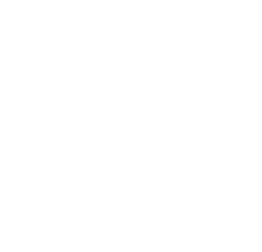

In [6]:
env = set_up_gym()
tf.app.run()